In [1]:
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.losses import Loss
from calibration_stats import ExpectedCalibrationError
import time 
from matplotlib import pyplot as plt

In [4]:
import sys
sys.path.insert(1, '/home/thlarsen/ood_detection')

from helper import load_dataset_c, load_cifar_model, rgb_img_to_vec, load_dataset_sev


In [5]:
data_by_sev = load_dataset_sev("contrast", "cifar")

label=3, sev=0
label=3, sev=1
label=3, sev=2
label=3, sev=3
label=3, sev=4
label=3, sev=5
label=3, sev=6
label=3, sev=7
label=3, sev=8
label=3, sev=9
label=3, sev=10


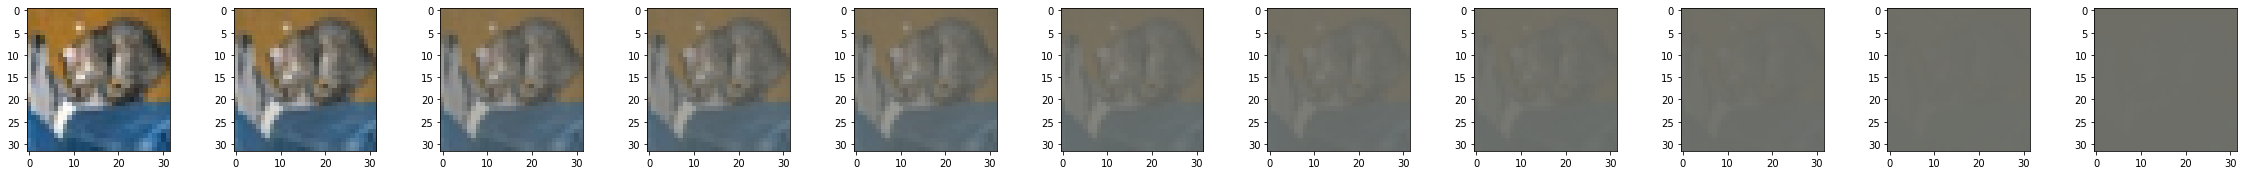

In [13]:

x=0

data_by_sev = load_dataset_sev('contrast', dataset='cifar')
# print(np.array(data).shape)
# print(np.array(labels).shape)
# print(np.array(sev).shape)

fig, axes = plt.subplots(nrows=1, ncols=len(data_by_sev.keys()), figsize=(32, 32))
fig.tight_layout(pad=3.0)

for sev in data_by_sev.keys(): 
    data_s, labels_s = data_by_sev[sev]    
    print(f'label={labels_s[0]}, sev={sev}')
    axes[x].imshow(data_s[0])
#     axes[x].title.set_text(f'sev={sev}')
#     axes[x].set_title(f'sev={sev}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
#     axes[x].set_fontsize(20)

    x+=1
plt.show()

In [5]:
# A=1
# B=60000
# x=0

# fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(32, 32))
# fig.tight_layout(pad=3.0)

# for i in range(A, A+B, 10000): 
    
#     print(f'label={labels[i]}, sev={sev[i]}')
#     axes[x].imshow(data[i])
# #     axes[x].title.set_text(f'sev={sev[i]}')
# #     ax.set_title(f'sev={sev[i]}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
# #     axes.set_fontsize(20)

#     x+=1
#     plt.show()
    

In [4]:
model = load_cifar_model(lr=1e-5, w=.1, train_on_shift=False) 

In [ ]:
lr=.001
w=.5
prefix = '/home/thlarsen/ood_detection/learn_uncertainty/'

model_save_path = f'{prefix}saved_weights/cifar_calibrate/2_cal(lr={lr})(w={w})'

model = keras.models.load_model(model_save_path)


In [7]:
acc_fn = keras.metrics.SparseCategoricalAccuracy()
ece = ExpectedCalibrationError()

In [8]:
data_by_sev = load_cifar_c_sev("brightness")

acc = []
ece = []

acc_fn = keras.metrics.Accuracy()
ECE = ExpectedCalibrationError()

for sev in data_by_sev.keys(): 
    data_s, labels_s = data_by_sev[sev]


    preds = model.predict(data_s)
    acc.append(acc_fn(labels_s, tf.argmax(preds, axis=1)))
    ece.append(ECE.call(labels_s, preds))
    print(f"sev = {sev}")
    print(f" acc = {acc[-1]}")
    print(f" ece = {ece[-1]}")


 acc = 0.3133000135421753
 ece = 0.11046271026134491
 acc = 0.3443000018596649
 ece = 0.07583066821098328
 acc = 0.3950999975204468
 ece = 0.025071531534194946
 acc = 0.43537500500679016
 ece = 0.007994658313691616
 acc = 0.47143998742103577
 ece = 0.00045592625974677503
 acc = 0.4868166744709015
 ece = 0.002026932081207633
 acc = 0.4754142761230469
 ece = 0.001528523163869977
 acc = 0.45368748903274536
 ece = 0.010440639220178127
 acc = 0.4282333254814148
 ece = 0.022011179476976395
 acc = 0.4057900011539459
 ece = 0.029952986165881157
 acc = 0.3867727220058441
 ece = 0.03420856222510338


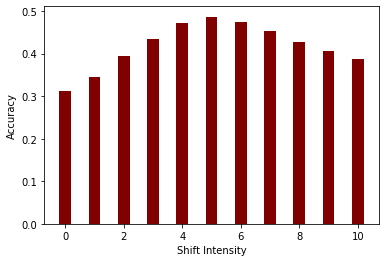

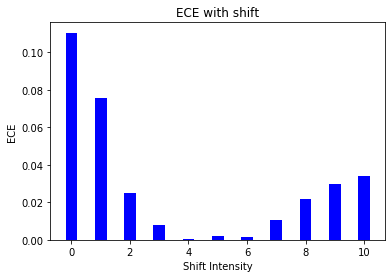

In [9]:


### Bar plots of a fixed model 
plt.bar(range(len(data_by_sev.keys())), acc, color ='maroon',
        width = 0.4)
 
plt.xlabel("Shift Intensity")
plt.ylabel("Accuracy")
plt.show()

plt.bar(range(len(data_by_sev.keys())), ece, color ='blue',
        width = 0.4)
 
plt.xlabel("Shift Intensity")
plt.ylabel("ECE")
plt.title("ECE with shift")
plt.show()

# for sev in range(5): 
    
#     print(f'label={labels[i]}, sev={sev[i]}')
#     axes[x].imshow(data[i])
#     axes[x].title.set_text(f'sev={sev[i]}')
#     ax.set_title(f'sev={sev[i]}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
#     axes.set_fontsize(20)

#     x+=1
#     plt.show()

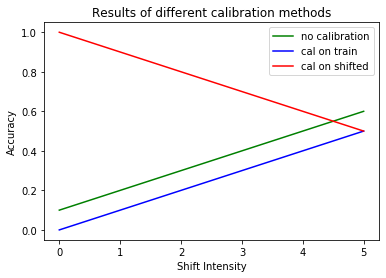

In [10]:
### line plots to compare for fixed model
# plt.bar(range(1, 6), acc, color ='maroon',
x = range(6)

#test arrays for graphing while waiting for results
acc = [1 - (x_v/10) for x_v in x]
ece = [(x_v/10) for x_v in x]
ece2 = [(x_v/10)+.1 for x_v in x]

fig = plt.figure()
ax = plt.axes()
ax.plot(x, ece2, color='green', label='no calibration')
ax.plot(x, ece, color='blue', label='cal on train')
ax.plot(x, acc,color='red', label='cal on shifted')
plt.xlabel("Shift Intensity")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Results of different calibration methods")
plt.show()




shift = Gaussian Noise


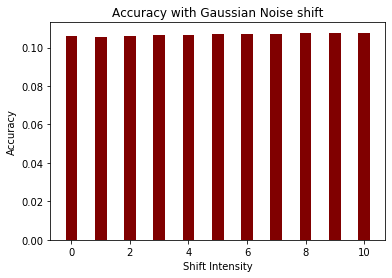

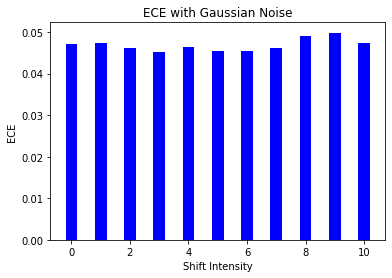

shift = Shot Noise


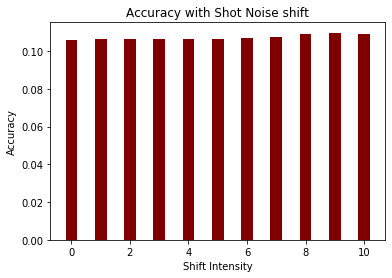

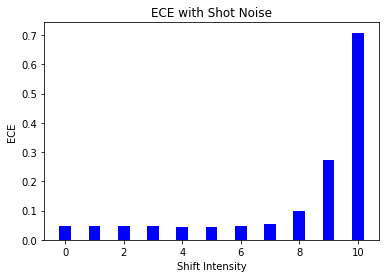

shift = Impulse Noise


In [ ]:
from helper import distribution_shifts
prefix = '/home/thlarsen/ood_detection/learn_uncertainty/'

for shift in distribution_shifts.keys(): 
    shift_name = distribution_shifts[shift]
    print(f"shift = {shift_name}")
    data_by_sev = load_cifar_c_sev(shift)

    acc = []
    ece = []

    acc_fn = keras.metrics.Accuracy()
    ECE = ExpectedCalibrationError()

    for sev in data_by_sev.keys(): 
        data_s, labels_s = data_by_sev[sev]
        preds = model.predict(data_s)
        acc.append(acc_fn(labels_s, tf.argmax(preds, axis=1)))
        ece.append(ECE.call(labels_s, preds))
#         print(f" acc = {acc[-1]}")
#         print(f" ece = {ece[-1]}")
    plt.bar(range(len(data_by_sev.keys())), acc, color ='maroon',
        width = 0.4)
 
    plt.xlabel("Shift Intensity")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy with {shift_name} shift")
    plt.savefig(prefix + f"graphs/{shift}_acc.png")
    plt.show()

    plt.bar(range(len(data_by_sev.keys())), ece, color ='blue',
            width = 0.4)

    plt.xlabel("Shift Intensity")
    plt.ylabel("ECE")
    plt.title(f"ECE with {shift_name}")
    plt.savefig(prefix + f"graphs/{shift}_ece.png")

    plt.show()